**CS-GY 9223: Deep Learning Final Project: Solving Natural Language Processing with Disaster Tweets on Kaggle with BERT**

by:

Yan Sun    <ys3928@nyu.edu>

Zhenming Wang <zw2365@nyu.edu>

**Section 3: BERT As Embedding**

Reference: (https://medium.com/@dhartidhami/understanding-bert-word-embeddings-7dc4d2ea54ca)

# Step 0: Set Up Working Environment And Libraries

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Deep Learning Final Project"   
                                       
%cd /content/gdrive/My Drive/Deep Learning Final Project

!pwd

/content/gdrive/My Drive/Deep Learning Final Project
/content/gdrive/My Drive/Deep Learning Final Project


In [3]:
!pip install -qq transformers

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Detect GPU
if torch.cuda.is_available():   
   device = torch.device("cuda")
   print('Using GPU ', torch.cuda.get_device_name(0))
else:
   device = torch.device("cpu")
   print('Using CPU')

     |████████████████████████████████| 1.4MB 13.6MB/s 
     |████████████████████████████████| 2.9MB 53.3MB/s 
     |████████████████████████████████| 890kB 63.7MB/s 
Using GPU  Tesla V100-SXM2-16GB


# Step 1: BERT Preprocessing

## 1.1 Read input data into dataframse

In [4]:
# Read in the data cleaned data files 
train = pd.read_csv('train_cleaned.csv')
test = pd.read_csv('test_cleaned.csv')


In [5]:
train.head()

,Unnamed: 0,id,keyword,location,text,target
0,0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1
1,1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1
2,2,5,NaN,NaN,All residents asked to shelter in place are be...,1
3,3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1


## 1.2 Helper function for tokenization and dataloader

In [6]:
# Helper function to tokenize a dataset using BERT tokenizer
class DisasterTweetDataset(Dataset):
  def __init__(self, text, targets, tokenizer, max_len):
    self.text = text
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.text)
  def __getitem__(self, item):
    text = str(self.text[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      truncation=True,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [7]:
# Helper function to create dataloaders
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = DisasterTweetDataset(
    text=df.text.to_numpy(),
    targets=df.target.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

## 1.3 BERT As Embedding Model

In [8]:
# Create a classifier that uses the BERT as Embedding
# Reference: (https://medium.com/@dhartidhami/understanding-bert-word-embeddings-7dc4d2ea54ca)
class BertAsEmbedding(nn.Module):
  def __init__(self, n_classes, embedding_type):
    super(BertAsEmbedding, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.1)
    self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.linear_last_four_concat = nn.Linear(4 * self.bert.config.hidden_size, n_classes)
    self.embedding_type = embedding_type

  def forward(self, input_ids, attention_mask):
    outputs = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      output_hidden_states=True
    )

    if self.embedding_type == 'last_hidden_layer':
      # outputs[0] is last_hidden_layer of size (batch_size, max_length, # of hidden units)
      # We want our output to be of size (batch_size, # of hidden units),
      # so we average across each token position within a sentence 
      x = torch.mean(outputs[0], dim=1)

    elif self.embedding_type == 'second_to_last_layer':
      # Perform similar average operation as 'last_hidden_layer'
      second_to_last_layer = outputs[2][-2]
      x = torch.mean(second_to_last_layer, dim=1)

    elif self.embedding_type == 'all_layers_sum':
      # outputs[2] contains the input embedding plus all 12 hidden layers
      # we drop the input embedding 
      
      # size of all_layers is: (# of layers, batch_size, max_length, # of hidden units)
      all_layers = outputs[2][1:]

      # First, sum all layers, sum_layers has the same size as last_hidden_layer
      sum_layers = torch.sum(all_layers, dim=0)

      # Then we average on max_length
      x = torch.mean(sum_layers, dim=1)
    
    elif self.embedding_type == 'last_four_layer_sum':
      # Similar to 'all_layers_sum'
      last_four_layer = outputs[2][-4:]

      # First, sum all 4 layers, sum_layers has the same size as last_hidden_layer
      sum_layers = torch.sum(last_four_layer, dim=0)

      # Then we average on max_length
      x = torch.mean(sum_layers, dim=1)
    
    elif self.embedding_type == 'last_four_concat':

      # Concatinate the last four hidden layers so that
      # x will have the shape (batch_size, max_length, 4 * # of hidden units)
      x = torch.cat((outputs[2][-1], 
              outputs[2][-2],
              outputs[2][-3],
              outputs[2][-4]),
              dim=2)
      
      # Average across max_length 
      # x will then have the shape (batch_size, 4 * # of hidden units)
      x = torch.mean(x, dim=1)


    x = self.drop(x)
    
    if self.embedding_type == 'last_four_concat':
      x = self.linear_last_four_concat(x)
    else:
      x = self.linear(x)
    
    return x


## 1.4 Training and Evaluating Epoch

In [9]:
# This method defines the operations in one trainning epoch
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0


  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

      
  return correct_predictions.double() / n_examples, np.mean(losses)

In [10]:
# This method defines the operations in one evaluating epoch
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

# Step 2: Training

## Train with Different Types of Embedding


In 1.3, we introduce 5 types of BERT embedding mechanism.

We will experiment with last_four_concat and check its performance.

### Train with last_four_concat As Embedding Type

In [11]:
# Define some constants
lr = 2e-5

PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
EPOCHS = 10
BATCH_SIZE = 32
DROPOUT = 0.3
MAX_LEN = 32
TOKENIZER = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [13]:
# Split the training data into train and validation set
train_data, val_data = train_test_split(train, test_size = 0.2, random_state=RANDOM_SEED) 

# Create dataloaders for training and validation set
train_data_loader = create_data_loader(train_data, TOKENIZER, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_data, TOKENIZER, MAX_LEN, BATCH_SIZE)

# Create model instance
model = BertAsEmbedding(2,'last_four_concat')
model = model.to(device)

# Define optimizer, loss fucntion and scheduler
optimizer = AdamW(model.parameters(), lr=lr, correct_bias=False)
loss_fn = nn.CrossEntropyLoss().to(device)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)


# Train the model for some number of epochs
history = defaultdict(list)

for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  # Train
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(train_data)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')

  # Validate
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(val_data)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)



Epoch 1/10
----------
Train loss 0.44854485988616943 accuracy 0.8036124794745485
Val   loss 0.39373555686324835 accuracy 0.8430728824688115
Epoch 2/10
----------
Train loss 0.2692079581515327 accuracy 0.8927750410509031
Val   loss 0.47191989080359537 accuracy 0.8246881155613919
Epoch 3/10
----------
Train loss 0.1506447879651181 accuracy 0.9463054187192118
Val   loss 0.7199223271260659 accuracy 0.8115561391989494
Epoch 4/10
----------
Train loss 0.0963771632459278 accuracy 0.9692939244663383
Val   loss 0.9049752227341136 accuracy 0.8253447143795141
Epoch 5/10
----------
Train loss 0.06923586934474565 accuracy 0.9768472906403941
Val   loss 0.9346042669688662 accuracy 0.8108995403808272
Epoch 6/10
----------
Train loss 0.05526324007494061 accuracy 0.9812807881773399
Val   loss 0.9681183309294283 accuracy 0.8115561391989494
Epoch 7/10
----------
Train loss 0.047517389339743504 accuracy 0.9830870279146141
Val   loss 1.0281238798052073 accuracy 0.8207485226526592
Epoch 8/10
----------
Train

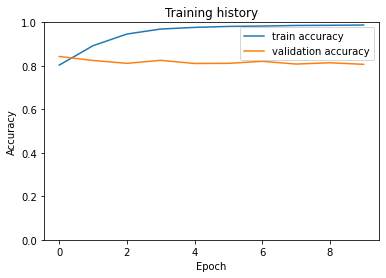

In [14]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Test with last_four_concat

In [15]:
BATCH_SIZE = 32
MAX_LEN = 32
TOKENIZER = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [16]:
# Create test dataloader
test_data_loader = create_data_loader(test, TOKENIZER, MAX_LEN, BATCH_SIZE)

In [17]:
# Make prediction on test set
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(test)
)

In [18]:
test_acc.item()

0.5853509040760037